In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Cardiac\ Project/Registration_phase/based \on \doc2

/content/drive/MyDrive/Cardiac Project/Registration_phase/based on doc2


In [106]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
from torchvision import transforms

import random
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.distributions.normal import Normal
import torch
torch.manual_seed(17)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
use_gpu = torch.cuda.is_available()

In [107]:
def read_dataset(path):

    dataset = []
    oks = os.listdir(path)
    for ok in tqdm(oks):
        ok_path = path + "/" + ok 
        patients = os.listdir(ok_path)
        i = 0
        for patient_id in  patients:
            folders_path = path + "/" + ok + "/" + patient_id
            
            folders = os.listdir(folders_path)
            folders = [folder for folder in folders if len(folder)==1]
            
            for folder in folders:
                result_path = path + "/" + ok + "/" + patient_id + "/" + folder + '/results/'
                i+=1
                if not os.path.exists(result_path):
                    continue                
                image_names = os.listdir(result_path)
                if len(image_names)>4:
                    for image_name in image_names:
                        
                        if "cine" in image_name:
                            cine_path = result_path + image_name
                            cine_image = cv2.imread(cine_path , cv2.IMREAD_GRAYSCALE)
                        
                        if "rigid_lge" in image_name and len(image_name) == 13:
                            lge_path = result_path + image_name
                            rigid_lge_image = cv2.imread(lge_path , cv2.IMREAD_GRAYSCALE) 


                        if "rigid_mask" in image_name :

                            mask_path = result_path + image_name
                            rigid_mask_image = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) 

                        if "scar_eliminated" in image_name:
                            el_path = result_path + image_name
                            scar_eliminated_image = cv2.imread(el_path , cv2.IMREAD_GRAYSCALE) 

                        else:
                            continue

                    dataset.append((cine_image , scar_eliminated_image , rigid_lge_image, rigid_mask_image, result_path ))
            
    print("Images Readed.")
    return dataset

In [108]:
dataset = read_dataset("dataset")

100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Images Readed.


In [109]:
len(dataset)

202

In [110]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.1, shuffle = False)

In [111]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [112]:
def transform(image , angle , flip_H , flip_V):
    image = rotate_image(image, angle)
    if flip_H:
        image = cv2.flip(image, 0)
    if flip_V:
        image = cv2.flip(image, 1)
    return image

In [113]:
def Augmentation(dataset , augment = False):
    new_dataset = []
    for element in dataset:
        transformed_element = []

        angle = random.randrange(start=-30, stop = 30 , step = 1)
        flip_H = random.choice([0,1])
        flip_V = random.choice([0,1])
        for image in element[:-1]:
            transformed_image = transform(image , angle , flip_H , flip_V)
            transformed_element.append(transformed_image)
        transformed_element = transformed_element + [element[-1]]
        new_dataset.append(transformed_element)
    return new_dataset

In [114]:
aug1 = Augmentation(train_dataset)

In [115]:
aug2 = Augmentation(train_dataset)

In [116]:
train_dataset =aug1 + aug2 + train_dataset

In [117]:
random.shuffle(train_dataset)

In [118]:
len(train_dataset)

543

path: dataset/ok1,2/1536189/4/results/


Text(0.5, 1.0, 'rigid mask')

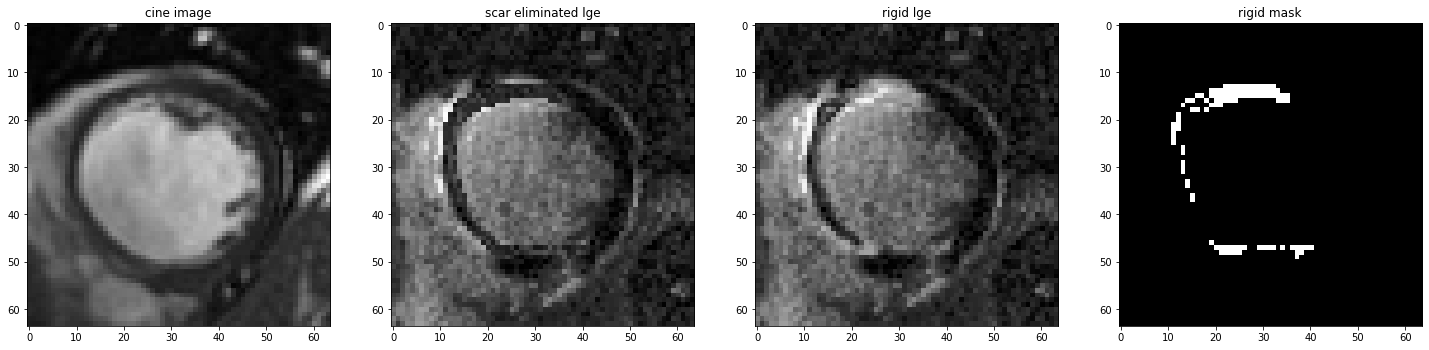

In [119]:
fig , (ax1 , ax2 , ax3 , ax4) = plt.subplots(1,4,figsize = (25,12))
cine_image , scar_eliminated_image , rigid_lge_image, rigid_mask_image  ,result_path = train_dataset[50]

print("path:" , result_path)

ax1.imshow(cine_image, cmap = 'gray')
ax1.set_title("cine image")

ax2.imshow(scar_eliminated_image , cmap = 'gray')
ax2.set_title("scar eliminated lge")

ax3.imshow(rigid_lge_image , cmap = 'gray')
ax3.set_title("rigid lge")

ax4.imshow(rigid_mask_image, cmap = 'gray')
ax4.set_title("rigid mask")

In [120]:
def preprocess(dataset):
    T_dataset = []
    for element in dataset:
        items = []
        for item in element[:-1]:
            item = transforms.ToTensor()(item)
            items.append(item)
        items = items + [element[-1]]
        T_dataset.append(items)
    return T_dataset

In [121]:
train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

In [122]:
train_loader = data.DataLoader(train_dataset , batch_size = 1, shuffle = False)  
test_loader = data.DataLoader(test_dataset ,batch_size = 1,shuffle = False)     

In [146]:
def default_unet_features():
    nb_features = [
        [16, 32, 32, 32],             # encoder
        [32, 32, 32, 32, 32, 16, 16]  # decoder
    ]
    return nb_features

In [147]:
class Unet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU(0.2),
        )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU(0.2),
        )
        return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.LeakyReLU(0.2)
                )
        return block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 128
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel * 2, padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel*2, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer


In [148]:

class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()
        self.main = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.main(x)
        out = self.activation(out)
        return out

In [149]:

class Unet(nn.Module):
    """
    A unet architecture. Layer features can be specified directly as a list of encoder and decoder
    features or as a single integer along with a number of unet levels. The default network features
    per layer (when no options are specified) are:
        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]
    """

    def __init__(self,
                 inshape=None,
                 infeats=None,
                 nb_features=None,
                 nb_levels=None,
                 max_pool=2,
                 feat_mult=1,
                 nb_conv_per_level=1,
                 half_res=False):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            infeats: Number of input features.
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. 
                If None (default), the unet features are defined by the default config described in 
                the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer. 
                Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. 
                Default is 1.
            nb_conv_per_level: Number of convolutions per unet level. Default is 1.
            half_res: Skip the last decoder upsampling. Default is False.
        """

        super().__init__()

        # ensure correct dimensionality
        
        ndims = 2
        # cache some parameters
        self.half_res = half_res

        # default encoder and decoder layer features if nothing provided
        if nb_features is None:
            nb_features = default_unet_features()

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            nb_features = [
                np.repeat(feats[:-1], nb_conv_per_level),
                np.repeat(np.flip(feats), nb_conv_per_level)
            ]
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')

        # extract any surplus (full resolution) decoder convolutions
        enc_nf, dec_nf = nb_features
        nb_dec_convs = len(enc_nf)
        final_convs = dec_nf[nb_dec_convs:]
        dec_nf = dec_nf[:nb_dec_convs]
        self.nb_levels = int(nb_dec_convs / nb_conv_per_level) + 1

        if isinstance(max_pool, int):
            max_pool = [max_pool] * self.nb_levels

        # cache downsampling / upsampling operations
        self.pooling = [nn.MaxPool2d(s) for s in max_pool]
        self.upsampling = [nn.Upsample(scale_factor=s, mode='nearest') for s in max_pool]

        # configure encoder (down-sampling path)
        prev_nf = infeats
        encoder_nfs = [prev_nf]
        self.encoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = enc_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.encoder.append(convs)
            encoder_nfs.append(prev_nf)

        # configure decoder (up-sampling path)
        encoder_nfs = np.flip(encoder_nfs)
        self.decoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = dec_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.decoder.append(convs)
            if not half_res or level < (self.nb_levels - 2):
                prev_nf += encoder_nfs[level]

        # now we take care of any remaining convolutions
        self.remaining = nn.ModuleList()
        for num, nf in enumerate(final_convs):
            self.remaining.append(ConvBlock(ndims, prev_nf, nf))
            prev_nf = nf

        # cache final number of features
        self.final_nf = prev_nf

    def forward(self, x):

        # encoder forward pass
        x_history = [x]
        for level, convs in enumerate(self.encoder):
            for conv in convs:
                x = conv(x)
            x_history.append(x)
            x = self.pooling[level](x)

        # decoder forward pass with upsampling and concatenation
        for level, convs in enumerate(self.decoder):
            for conv in convs:
                x = conv(x)
            if not self.half_res or level < (self.nb_levels - 2):
                x = self.upsampling[level](x)
                x = torch.cat([x, x_history.pop()], dim=1)

        # remaining convs at full resolution
        for conv in self.remaining:
            x = conv(x)

        return x


In [150]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


class VecInt(nn.Module):
    """
    Integrates a vector field via scaling and squaring.
    """

    def __init__(self, inshape, nsteps):
        super().__init__()
        
        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(inshape)

    def forward(self, vec):
        vec = vec * self.scale
        for _ in range(self.nsteps):
            vec = vec + self.transformer(vec, vec)
        return vec


class ResizeTransform(nn.Module):
    """
    Resize a transform, which involves resizing the vector field *and* rescaling it.
    """

    def __init__(self, vel_resize, ndims):
        super().__init__()
        self.factor = 1.0 / vel_resize
        self.mode = 'linear'
        if ndims == 2:
            self.mode = 'bi' + self.mode
        elif ndims == 3:
            self.mode = 'tri' + self.mode

    def forward(self, x):
        if self.factor < 1:
            # resize first to save memory
            x = F.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)
            x = self.factor * x

        elif self.factor > 1:
            # multiply first to save memory
            x = self.factor * x
            x = F.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)

        # don't do anything if resize is 1
        return x

In [200]:
import torch
import torch.nn.functional as F
import numpy as np
import math


class NCC:
    """
    Local (over window) normalized cross correlation loss.
    """

    def __init__(self, win=None):
        self.win = win

    def loss1(self, y_true, y_pred):
        
        I = y_true
        J = y_pred

        # get dimension of volume
        # assumes I, J are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(list(I.size())) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims
        # set window size
        win = [9] * ndims if self.win is None else self.win

        # compute filters
        sum_filt = torch.ones([1, 1, *win]).to("cuda")

        pad_no = math.floor(win[0]/2)

        # get convolution function
        conv_fn = getattr(F, 'conv%dd' % ndims)

        # compute CC squares
        I2 = I * I
        J2 = J * J
        IJ = I * J
        I_sum = conv_fn(I, sum_filt, stride=(1,1), padding=1)
        J_sum = conv_fn(J, sum_filt, stride=(1,1), padding=1)
        I2_sum = conv_fn(I2, sum_filt, stride=(1,1), padding=1)
        J2_sum = conv_fn(J2, sum_filt, stride=(1,1), padding=1)
        IJ_sum = conv_fn(IJ, sum_filt, stride=(1,1), padding=1)

        win_size = np.prod(win)
        u_I = I_sum / win_size
        u_J = J_sum / win_size

        cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size

        cc = cross * cross / (I_var * J_var + 1e-5)

        return -torch.mean(cc)
    
    def loss(self, y_true, y_pred):
        n = 9
        I = y_true
        J = y_pred
        batch_size, channels, xdim, ydim = I.shape
        I2 = torch.mul(I, I)
        J2 = torch.mul(J, J)
        IJ = torch.mul(I, J)
        sum_filter = torch.ones((1, channels, n, n))
        sum_filter = sum_filter.to("cuda")
        I_sum = torch.conv2d(I, sum_filter, padding=1, stride=(1,1))
        J_sum = torch.conv2d(J, sum_filter,  padding=1 ,stride=(1,1))
        I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=(1,1))
        J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=(1,1))
        IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=(1,1))
        win_size = n**2
        u_I = I_sum / win_size
        u_J = J_sum / win_size
        cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size
        cc = cross*cross / (I_var*J_var + np.finfo(float).eps)
        return torch.mean(cc)


class MSE:
    """
    Mean squared error loss.
    """

    def loss(self, y_true, y_pred):
        return torch.mean((y_true - y_pred) ** 2)


class Dice:
    """
    N-D dice for segmentation
    """

    def loss(self, y_true, y_pred):
        ndims = len(list(y_pred.size())) - 2
        vol_axes = list(range(2, ndims+2))
        top = 2 * (y_true * y_pred).sum(dim=vol_axes)
        bottom = torch.clamp((y_true + y_pred).sum(dim=vol_axes), min=1e-5)
        dice = torch.mean(top / bottom)
        return -dice


class Grad:
    """
    N-D gradient loss.
    """

    def __init__(self, penalty='l2', loss_mult=None):
        self.penalty = penalty
        self.loss_mult = loss_mult

    def loss(self, _, y_pred):
        y_pred = y_pred.permute(0,2,3,1)

        dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]) 
        dx = torch.abs(y_pred[ :, :, 1:, :] - y_pred[:, :, :-1, :]) 

        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx

        d = torch.mean(dx) + torch.mean(dy) 
        grad = d / 2.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad

def VoxelMorphLoss(y_true , y_pred):
    ncc_loss = nnc.loss(y_true, y_pred)
    sm = smooth_loss.loss(_ , y_pred)
    print(ncc_loss , sm)
    return ncc_loss + 0.01 * sm

In [201]:
class VoxelMorph2d(nn.Module):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    def __init__(self,
                 inshape,
                 nb_unet_features=None,
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 nb_unet_conv_per_level=1,
                 int_steps=7,
                 int_downsize=2,
                 bidir=False,
                 use_probs=False,
                 src_feats=1,
                 trg_feats=1,
                 unet_half_res=False):
        """ 
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. 
                If None (default), the unet features are defined by the default config described in 
                the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_features is an integer. 
                Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. 
                Default is 1.
            nb_unet_conv_per_level: Number of convolutions per unet level. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this 
                value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration. 
                The flow field is not downsampled when this value is 1.
            bidir: Enable bidirectional cost function. Default is False.
            use_probs: Use probabilities in flow field. Default is False.
            src_feats: Number of source image features. Default is 1.
            trg_feats: Number of target image features. Default is 1.
            unet_half_res: Skip the last unet decoder upsampling. Requires that int_downsize=2. 
                Default is False.
        """
        super().__init__()

        # internal flag indicating whether to return flow or integrated warp during inference
        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            infeats=(src_feats + trg_feats),
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult,
            nb_conv_per_level=nb_unet_conv_per_level,
            half_res=unet_half_res,
        )

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.flow = Conv(self.unet_model.final_nf, ndims, kernel_size=3, padding=1)

        # init flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        # probabilities are not supported in pytorch
        if use_probs:
            raise NotImplementedError(
                'Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure optional resize layers (downsize)
        if not unet_half_res and int_steps > 0 and int_downsize > 1:
            self.resize = ResizeTransform(int_downsize, ndims)
        else:
            self.resize = None

        # resize to full res
        if int_steps > 0 and int_downsize > 1:
            self.fullsize = ResizeTransform(1 / int_downsize, ndims)
        else:
            self.fullsize = None

        # configure bidirectional training
        self.bidir = bidir

        # configure optional integration layer for diffeomorphic warp
        down_shape = [int(dim / int_downsize) for dim in inshape]
        self.integrate = VecInt(down_shape, int_steps) if int_steps > 0 else None

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, source, target, registration=False):
        '''
        Parameters:
            source: Source image tensor.
            target: Target image tensor.
            registration: Return transformed image and flow. Default is False.
        '''

        # concatenate inputs and propagate unet
        x = torch.cat([source, target], dim=1)
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        # resize flow for integration
        pos_flow = flow_field
        if self.resize:
            pos_flow = self.resize(pos_flow)

        preint_flow = pos_flow

        # negate flow for bidirectional model
        neg_flow = -pos_flow if self.bidir else None

        # integrate to produce diffeomorphic warp
        if self.integrate:
            pos_flow = self.integrate(pos_flow)
            neg_flow = self.integrate(neg_flow) if self.bidir else None

            # resize to final resolution
            if self.fullsize:
                pos_flow = self.fullsize(pos_flow)
                neg_flow = self.fullsize(neg_flow) if self.bidir else None

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)
        y_target = self.transformer(target, neg_flow) if self.bidir else None

        # return non-integrated flow field if training
        if not registration:
            return (y_source, y_target, preint_flow) if self.bidir else (y_source, preint_flow)
        else:
            return y_source, pos_flow

In [202]:
def train_VoxelMorph(model , train_loader ,epochs , save_model = False , model_name=None):
    
    for epoch in range(epochs):
        best_loss = 0
        epoch_loss = 0
        epoch_dice = 0
        for cine_batch , scar_eliminated_batch , rigid_lge_batch , rigid_mask_batch , results_batch in train_loader:
            optimizer.zero_grad()

            cine_batch = cine_batch.to(device)
            scar_eliminated_batch = scar_eliminated_batch.to(device)
            rigid_lge_batch = rigid_lge_batch.to(device)

            registered_batch , _ = model(scar_eliminated_batch , cine_batch)

            train_loss = VoxelMorphLoss(cine_batch , registered_batch)
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
        print(epoch , epoch_loss/len(train_dataset) )

        if save_model:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                PATH = model_name + ".pt" 
                torch.save(model.state_dict(), PATH)
        #if np.abs(-1*(epoch_loss/len(train_dataset)) - (last_loss)) > 0.03:
            #break


In [203]:
model = VoxelMorph2d(inshape = (64 , 64),
                nb_unet_features=default_unet_features(),
                nb_unet_levels=None,
                unet_feat_mult=1,
                int_steps=1,
                int_downsize=1,
                bidir=False,
                use_probs=False)

model = model.to(device)

In [204]:
nnc = NCC()
smooth_loss = Grad()

In [205]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [206]:
train_VoxelMorph(model , train_loader , epochs = 300 , model_name = None , save_model=False)

tensor(0.3231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0093, device='cuda:0', grad_fn

KeyboardInterrupt: ignored

In [ ]:
def test(model , test_loader):
    with torch.no_grad():
        all_loss = 0
        d = []
        for fixed_batch , moving_batch , rigid_lge_batch, rigid_mask_batch ,result_path_batch  in test_loader:
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            rigid_lge_batch = rigid_lge_batch.to(device)
            rigid_mask_batch = rigid_mask_batch.to(device)
            registered_images , df = model(moving_batch , fixed_batch)
            test_loss = VoxelMorphLoss(registered_images, fixed_batch)
            all_loss += test_loss.item()
            d.append((fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch,  df ))
        print(all_loss/len(test_dataset)) 
        return fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch,  df , d   

In [ ]:
fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch,  df  ,d= test(model , test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.30728296596895566


In [ ]:
fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch , df= d[3]

In [ ]:
ST = SpatialTransformation(use_gpu=True)

In [ ]:
voxel_mask = ST(rigid_mask_batch , df)

In [ ]:
voxel_lge = ST(rigid_lge_batch , df)

dataset/ok4/1506521/5/results/


Text(0.5, 1.0, 'rigid mask AFTER')

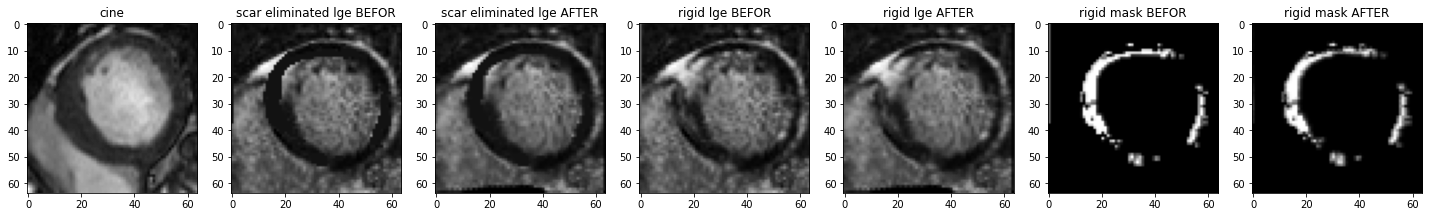

In [ ]:
sample =0
fig , (ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7) = plt.subplots(1,7,figsize = (25,12))
print(result_path_batch[sample])
ax1.imshow(fixed_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax1.set_title("cine")
ax2.imshow(moving_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax2.set_title("scar eliminated lge BEFOR")
ax3.imshow(registered_images[sample].squeeze(0).cpu() , cmap = 'gray')
ax3.set_title("scar eliminated lge AFTER")
ax4.imshow(rigid_lge_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax4.set_title("rigid lge BEFOR")
ax5.imshow(voxel_lge[sample].squeeze(0).cpu() , cmap = 'gray')
ax5.set_title("rigid lge AFTER")
ax6.imshow(rigid_mask_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax6.set_title("rigid mask BEFOR")
ax7.imshow(voxel_mask[sample].squeeze(0).cpu() , cmap = 'gray')
ax7.set_title("rigid mask AFTER")